<a href="https://colab.research.google.com/github/Digital-Image-Processing-IIITH/project-image-processors/blob/global-matching/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive',force_remount=True)

Mounted at /gdrive


In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
from math import floor,exp,sqrt
import cv2
from timeit import default_timer as timer
from google.colab.patches import cv2_imshow
from zipfile import ZipFile 
# from decord import VideoReader
# from decord import cpu, gpu

In [3]:
# data-paths
DATA="/gdrive/My Drive/dip-project/DIP_PROJECT_DATABASE"
IMAGES_FOLDER_PATH="/gdrive/My Drive/dip-project/DIP_PROJECT_DATABASE/Images"
DATA_PATH = "/gdrive/My Drive/dip-project/DIP_PROJECT_DATABASE/videos_h264"

# Helper Functions

In [5]:
def get_image(img_name,colored=1):
  if colored==0:
    img=cv2.imread(os.path.join(IMAGES_FOLDER_PATH,img_name),0)
    return img
  img=cv2.imread(os.path.join(IMAGES_FOLDER_PATH,img_name))
  return  img

In [6]:
def resize_img(img,shape):
  return cv2.resize(img,shape,interpolation=cv2.INTER_AREA)

In [7]:
def normalise_img(img):
  return cv2.normalize(img,None,0,255,cv2.NORM_MINMAX)

In [8]:
def pad_img(img,k):
  m,n=img.shape
  l=k//2
  if (k%2) ==0:
    l-=1
  m1,n1=(m+k-1,n+k-1)
  pd=np.zeros((m1,n1),dtype='int')   # padding
  pd[l:m+l,l:n+l]=np.copy(img)
  return pd

In [9]:
def remove_padding_img(img,k):
  m,n=img.shape
  l=k//2
  if (k%2)==0:
    l-=1
  return img[l:m-k//2,l:n-k//2]

In [10]:
def bgr2rgb(bgr):
 rgb = bgr[...,::-1]
 return rgb

In [11]:
def show_imgs(images,titles,rows,cols):
  fib,a=plt.subplots(rows,cols,sharex=True,sharey=True,figsize=(15,15))
  plt.gray()
  counter=1
  if rows ==1 or cols==1:
    for i in range(0,max(rows,cols)):
      a[i].imshow(bgr2rgb(images[counter-1]))

      a[i].set_title(titles[i])
      counter=counter+1
  else:
    for i in range(0,rows):
      for j in range(0,cols):
        a[i][j].imshow(bgr2rgb(images[counter-1]))
        a[i][j].set_title(titles[counter-1])
        counter=counter+1
  plt.show()

## Step 1: Load the Image and all the videos


In [12]:
def loadVideos():
  videos=[]
  for file_name in os.listdir(DATA_PATH):
    videos.append(file_name)
  videos=np.array(videos)
  return videos

In [13]:
videos = loadVideos()
assert len(videos)!=0

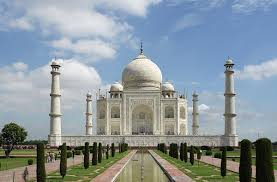

In [14]:
img=get_image('taj_mahal.jpeg')
cv2_imshow(img)

## Step2 : Function to get equally spaced frames from a video

In [15]:
def video2frames(video_path,n):
    """
    Input: 
      1. video_path: path to a video file
      2. n: number of equally spaced frames to be returned
    Output:
      returns n equally spaced frames from the video.
    """
    vidcap = cv2.VideoCapture(video_path)
    total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
    frames_step = total_frames//n
    frames=[]
    for i in range(n):
        #here, we set the parameter 1 which is the frame number to the frame (i*frames_step)
        vidcap.set(1,i*frames_step)
        success,image = vidcap.read()  
        #save your image
        frames.append(image)
    
    vidcap.release()
    return frames

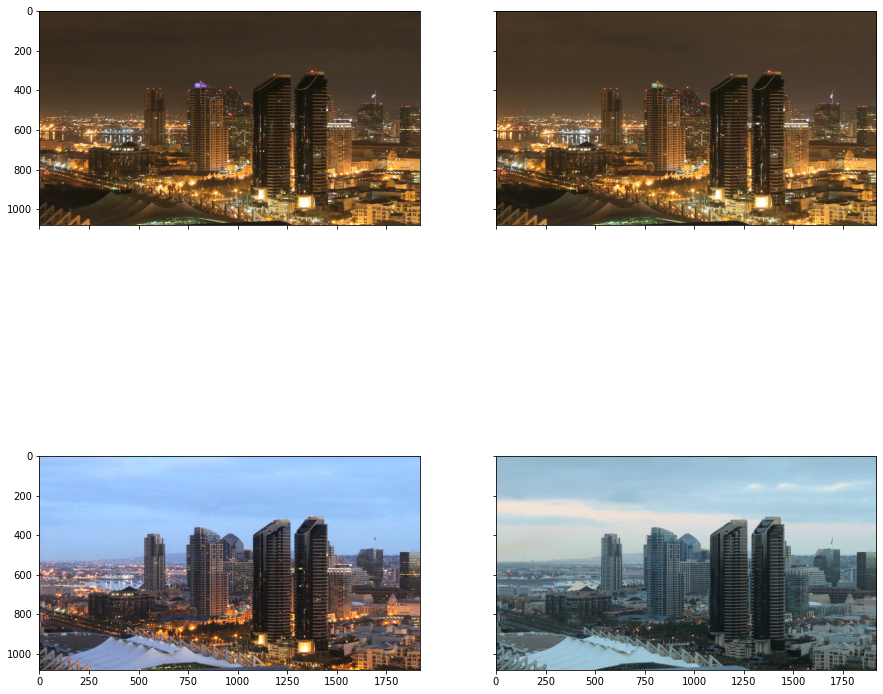

In [16]:
video1=videos[0]
frames=video2frames(os.path.join(DATA_PATH,video1),4)
show_imgs(frames,["","","",""],2,2)

## Step 3 :Pyramid Hog Algorithm (For finding descriptors)

In [17]:
words=np.load(os.path.join(DATA,'words.npy'))

In [18]:
def reduced_HoG_Features(image, stride=8):
    '''Takes colored image as input'''
    image = np.array(image).astype(np.double)
    w,h,_ = image.shape              
    ## overall usecase : for finding useful descriptor for checking similarity b/w frame and img                          
    epsilon = 0.00001 
    # unit vectors used to compute gradient orientation
    x_component = np.array([1.0000, 0.9397, 0.7660, 0.500, 0.1736, -0.1736, -0.5000, -0.7660, -0.9397]).astype(np.double)
    y_component = np.array([0.0000, 0.3420, 0.6428, 0.8660, 0.9848, 0.9848, 0.8660, 0.6428, 0.3420]).astype(np.double)
    
    blocks = (w//stride, h//stride)
    histograms = np.zeros((w//stride, h//stride, 18))
    
    output_features = np.zeros((w//stride - 2, h//stride - 2, 31))
    
    visible_x = w//stride * stride
    visible_y = h//stride * stride
    
    for x in range(1,visible_x-1):
        for y in range(1,visible_y-1):
            magnitude = grad_x = grad_y = 0
            for k in range(3):
                grad_x_k = image[x+1][y][k] - image[x-1][y][k]
                grad_y_k = image[x][y+1][k] - image[x][y-1][k]
                magnitude_k = grad_x_k**2 + grad_y_k**2
                # Select the strongest gradient
                if magnitude < magnitude_k:
                    magnitude = magnitude_k
                    grad_x = grad_x_k
                    grad_y = grad_y_k
            magnitude = sqrt(magnitude)
            #Place the gradient in a bin of 20 degrees each
            best_dot = best_orientation = 0
            for o in range(9):
                dot = x_component[o] * grad_x + y_component[o] * grad_y
                if best_dot < dot:
                    best_dot = dot
                    best_orientation = o
                elif best_dot < -dot:
                    # This handles directed edges
                    best_dot = -dot
                    best_orientation = o + 9
            # add to 4 histograms around pixel using linear interpolation
            xp = (x+0.5)/stride - 0.5
            yp = (y+0.5)/stride - 0.5
            ixp = floor(xp)
            iyp = floor(yp)
            vx = xp-ixp
            vy = yp-iyp
            if ixp >=0 and iyp >=0: histograms[ixp][iyp][best_orientation] += (1-vx) * (1-vy) * magnitude 
            if ixp+1 < blocks[1] and iyp >=0: histograms[ixp+1][iyp][best_orientation] += vx * (1-vy) * magnitude
            if ixp >=0 and iyp+1 < blocks[0]: histograms[ixp][iyp+1][best_orientation] += (1-vx) * vy * magnitude 
            if ixp+1 < blocks[1] and iyp+1 < blocks[0]: histograms[ixp+1][iyp+1][best_orientation] += vx * vy * magnitude 
    #normalizing factors
    norm_fac = np.sum(histograms,axis=2)
    
    #write reduced features
    out_x = w//stride - 2
    out_y = h//stride - 2
    for x in range(out_x):
        for y in range(out_y):
            n1 = 1.0/sqrt(norm_fac[x+1][y+1]+norm_fac[x+2][y+1]+norm_fac[x+1][y+2]+norm_fac[x+2][y+2]+epsilon)
            n2 = 1.0/sqrt(norm_fac[x+1][y]+norm_fac[x+2][y]+norm_fac[x+1][y+1]+norm_fac[x+2][y+1]+epsilon)
            n3 = 1.0/sqrt(norm_fac[x][y+1]+norm_fac[x+1][y+1]+norm_fac[x][y+2]+norm_fac[x+1][y+2]+epsilon)
            n4 = 1.0/sqrt(norm_fac[x][y]+norm_fac[x+1][y]+norm_fac[x][y+1]+norm_fac[x+1][y+1]+epsilon)
            t1 = t2 = t3 = t4 = 0
            for o in range(18):
                h1 = min(histograms[x+1][y+1][o] * n1, 0.2)
                h2 = min(histograms[x+1][y][o] * n2, 0.2)
                h3 = min(histograms[x][y+1][o] * n3, 0.2)
                h4 = min(histograms[x][y][o] * n4, 0.2)
                output_features[x][y][o] = 0.5 * (h1+h2+h3+h4)
                t1 += h1
                t2 += h2
                t3 += h3
                t4 += h4
            for o in range(9):
                h1 = min((histograms[x+1][y+1][o] + histograms[x+1][y+1][o+9]) * n1, 0.2)
                h2 = min((histograms[x+1][y][o] + histograms[x+1][y][o+9]) * n2, 0.2)
                h3 = min((histograms[x][y+1][o] + histograms[x][y+1][o+9]) * n3, 0.2)
                h4 = min((histograms[x][y][o] + histograms[x][y][o+9]) * n4, 0.2)
                output_features[x][y][o+18] = 0.5 * (h1+h2+h3+h4)
            output_features[x][y][27] = 0.2357 * t1
            output_features[x][y][28] = 0.2357 * t2
            output_features[x][y][29] = 0.2357 * t3
            output_features[x][y][30] = 0.2357 * t4
    return output_features

In [19]:
def stack_neigbours(features):
    W,H,_ = features.shape
    W = W - 1
    H = H - 1
    descriptors = np.zeros((124,W * H))
    for i in range(W):
        for j in range(H):
            n = i * H + j
            descriptors[:31,n] = np.uint8(features[i,j] * 255)
            descriptors[31:62,n] = np.uint8(features[i+1,j] * 255)        
            descriptors[62:93,n] = np.uint8(features[i,j+1] * 255)        
            descriptors[93:,n] = np.uint8(features[i+1,j+1] * 255)

#     print(descriptors.shape)
    return descriptors

In [20]:
def word2vec(descriptors):
    word_histogram = np.zeros(300).astype(np.int16)
    n = descriptors.shape[1]
    for i in range(n):
        distances = np.sum((words.T - descriptors[:,i])**2, axis=1)
        word_histogram[np.argmin(distances)] += 1
    return word_histogram

In [21]:
def hog_pipeline(image):
    features = reduced_HoG_Features(image)
    descriptors = stack_neigbours(features)
    word_histogram = word2vec(descriptors)
    return word_histogram

In [22]:
def pyramid_hog(image,levels=2):
    image = cv2.resize(image,(256,256),cv2.INTER_CUBIC)
    w,h,_ = image.shape
    descriptors = []
    for level in range(levels+1):
        level_descriptors = []
        for i in range(2**level):
            for j in range(2**level):
                image_part = image[i*(w//(2**level)):(i+1)*(w//(2**level)),j*(h//(2**level)):(j+1)*(h//(2**level))]
                temp = hog_pipeline(image_part)
                level_descriptors.append(temp)
        
        descriptors.append(level_descriptors)
    return descriptors

In [23]:
image_descriptor=pyramid_hog(img)  

In [24]:
def getVideoDiscriptors(videosList,mode,numframes=5,numDescriptors=10):
  """
  input:
    1. videosList : A list of strings that have represent the relative path to video files.
    2. numframes : number of frames per video for which descriptors are to be found.
    3. numDescriptors: number of videos for which descriptors will be found.

  output:
    array of discriptors 
  """
  video_descriptors=[]
  hog = cv2.HOGDescriptor()
  count=0
  for video in videosList:
    frames=video2frames(os.path.join(DATA_PATH,video),numframes)
    descriptors=[]
    for frame in frames:
      if mode == 'pyramid_hog':
        descriptors.append(pyramid_hog(frame))
      elif mode == 'hog':
         descriptors.append(hog.compute(resize_img(frame,(64,128))))
      else:
        print("Invalid mode. Choose between: \n 1.pyramid_hog \n 2.hog \n")
    video_descriptors.append(descriptors)
    print("Completed finding video descriptors for video {}".format(count))
    count+=1
    if count >=numDescriptors:
      break
  return video_descriptors

In [27]:
videos = loadVideos()
assert len(videos)!=0
video_pyramid_hog_descriptors = getVideoDiscriptors(videos,'pyramid_hog')

Completed finding video descriptors for video 0
Completed finding video descriptors for video 1
Completed finding video descriptors for video 2
Completed finding video descriptors for video 3
Completed finding video descriptors for video 4
Completed finding video descriptors for video 5
Completed finding video descriptors for video 6
Completed finding video descriptors for video 7
Completed finding video descriptors for video 8
Completed finding video descriptors for video 9


In [ ]:
 # len(video_descriptors)

## Step 4: Finding similarity b/w two descriptors using pyramid intersection and histogram intersection.

In [28]:
def histogram_intersection(hist_A, hist_B):
    return np.sum(np.minimum(hist_A, hist_B))

In [29]:
def pyramid_intersection(pyramid_hist_A, pyramid_hist_B):
    levels = len(pyramid_hist_A)
    score = 0
    for level in range(levels):
        weight = 1.0/2**(levels-level)
        for region in range(2**level):
            similarity = histogram_intersection(pyramid_hist_A[level][region],pyramid_hist_B[level][region])
            score += weight * similarity
    return score

In [30]:
def assign_score(videos,image,mode):
  scores=[]
  for video in videos:
    score=Max_similarity(image,video,mode)
    scores.append(score)
  return scores

## Step5 : Assign score to each video based on maximum similarity with any of its frame and the image

In [31]:
def Max_similarity(image_descriptor,video_descriptors,mode):
  max_score=0
  for video_descriptor in video_descriptors:
    if mode=='pyramid_hog':
      score=pyramid_intersection(image_descriptor,video_descriptor)
    elif mode == 'hog':
      score=intersection(image_descriptor,video_descriptor)
    else:
      print('Invalid `mode` Atrribute')
    max_score=max(max_score,score)
  return max_score

In [33]:
#pyramid hog scores
ph_scores=assign_score(video_pyramid_hog_descriptors,image_descriptor,'pyramid_hog')

In [34]:
print(ph_scores)

[186.0, 180.875, 186.125, 188.375, 182.0, 187.125, 185.0, 180.625, 177.75, 187.375]


## Step 6 : Select best videos based on assigned scores

In [35]:
def getKbestVideos(vidoes,scores,k=5):
  arr=[]
  for i in range(len(scores)):
    arr.append([scores[i],videos[i]])
  arr.sort(reverse=True)
  return arr[:k]

In [37]:
arr = getKbestVideos(videos,ph_scores,5)

In [38]:
for i in arr:
  print(i[1])

012411_12_TL.mp4
04_16_2012_15_58_53.mp4
012411_2_TL.mp4
012411_11_TL.mp4
011711_TL_10.mp4


In [39]:
hog = cv2.HOGDescriptor()
h = hog.compute(resize_img(img,(64,128)))

In [40]:
print(h.shape)

(3780, 1)


In [41]:
hog_descriptors = getVideoDiscriptors(videos,"hog")

Completed finding video descriptors for video 0
Completed finding video descriptors for video 1
Completed finding video descriptors for video 2
Completed finding video descriptors for video 3
Completed finding video descriptors for video 4
Completed finding video descriptors for video 5
Completed finding video descriptors for video 6
Completed finding video descriptors for video 7
Completed finding video descriptors for video 8
Completed finding video descriptors for video 9


In [42]:
def intersection(hog1,hog2):
  return np.sqrt(np.sum((hog1-hog2)*(hog1-hog2)))

In [43]:
hog_scores=assign_score(hog_descriptors,h,"hog")

In [44]:
print(hog_scores)

[8.14781, 8.039308, 7.812103, 7.9627695, 7.1463766, 8.022579, 7.5151286, 8.661148, 10.229919, 8.978436]


In [45]:
arr = getKbestVideos(videos,hog_scores)
for i in arr:
  print(i[1])

04_16_2012_15_58_32.mp4
04_16_2012_15_58_53.mp4
012411_6_TL.mp4
011711_TL_10.mp4
011711_TL_18.mp4


# Step 7 : Select best frame for video.


In [ ]:

def videoReader(video,play=False):
    cap = cv2.VideoCapture(video)
    if (cap.isOpened() == False): 
        print("Error opening video stream or file")

    return cap

In [ ]:
cap = videoReader(DATA_PATH+ '/Dubai_Sunrise.mp4')
numberOfFrames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
print(numberOfFrames,width,height)

738 1440 1080


In [ ]:
img=get('taj_mahal.jpeg')
height, width = img.shape[:2]
print(height, width)

182 277


In [ ]:

def getHistogram(image):
    hist_r = cv2.calcHist([image],[0],None,[255],[0,256]) 
    hist_g = cv2.calcHist([image],[1],None,[255],[0,256]) 
    hist_b = cv2.calcHist([image],[2],None,[255],[0,256])
    
    hist = np.vstack((hist_r,hist_g,hist_b))
    normalize = image.shape[0]*image.shape[1]*image.shape[2]
    hist = hist/normalize
    return hist

In [ ]:
def getMatchingFrame(image,video):
   
    
    imageHist = getHistogram(image)
    min_distance = 10000000
    min_index = 0
    
    for i in range(0,numberOfFrames, 30):
        video.set(cv2.CAP_PROP_POS_FRAMES, i)
        _, frame = video.read()
        curHist = getHistogram(frame)
        distance = np.linalg.norm(curHist - imageHist)
        if min_distance > distance:
            min_distance = distance
            min_index = i
    
    video.set(cv2.CAP_PROP_POS_FRAMES, min_index)
    _, matched_frame = video.read()

    matched_frame = cv2.resize(matched_frame,(image.shape[1],image.shape[0]),cv2.INTER_CUBIC)
    return matched_frame, min_index

In [ ]:
matched_frame, matched_frame_index = getMatchingFrame(img,cap)


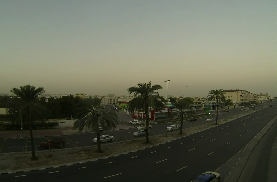

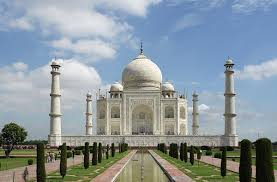

In [ ]:

cv2_imshow(matched_frame)
cv2_imshow(img)